<a href="https://colab.research.google.com/github/itoshiyanazawa/rnn_project/blob/main/test_Itoshi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [10]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 26.0 MB/s eta 0:00:00


In [11]:
import urllib.request
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import visualkeras

In [2]:
# Establish GPU runtime for faster development
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Step 1

1. Collect the text dataset:
  *   Download the text dataset from a reputable source or use a pre-existing one.

2. Clean the text data:
  *   Remove unwanted characters, punctuation, and formatting.
  *  Convert all text to lowercase to reduce complexity.

3. Tokenize the text:
  *   Split the text into individual characters.
  *   Create a vocabulary of unique tokens and map each token to an integer.

4. Create input sequences:
  *   Generate input sequences and corresponding targets for training.



Collecting the Movie Dialogues dataset from the Cornell University Website

In [3]:
url = "http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip"
file_name = "cornell_movie_dialogs_corpus.zip"

# Download the dataset
urllib.request.urlretrieve(url, file_name)

# Extract the dataset
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall("cornell_data")

print("✅ Dataset downloaded and extracted.")


✅ Dataset downloaded and extracted.


Cleaning the Text Data

In [4]:
# Load dialogue lines
with open("cornell_data/cornell movie-dialogs corpus/movie_lines.txt", encoding='iso-8859-1') as f:
    lines = f.readlines()

# Extract the actual text (5th field) from each line
dialogues = []
for line in lines:
    parts = line.split(" +++$+++ ")
    if len(parts) == 5:
        dialogues.append(parts[-1].strip())

# Clean the text
import re

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"[^a-zA-Z0-9.,!?'\n ]+", ' ', text)  # remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # normalize spacing
    return text

cleaned_dialogues = [clean_text(line) for line in dialogues]

# Combine into one long string
full_text = ' '.join(cleaned_dialogues)

print("🧹 Cleaned text preview:\n", full_text[:500])


🧹 Cleaned text preview:
 they do not! they do to! i hope so. she okay? let's go. wow okay you're gonna need to learn how to lie. no i'm kidding. you know how sometimes you just become this persona ? and you don't know how to quit? like my fear of wearing pastels? the real you . what good stuff? i figured you'd get to the good stuff eventually. thank god! if i had to hear one more story about your coiffure... me. this endless ...blonde babble. i'm like, boring myself. what crap? do you listen to this crap? no... then gui


Tokenize the text

In [5]:
# Character-level tokenization
chars = sorted(set(full_text))  # unique characters
char2idx = {ch: idx for idx, ch in enumerate(chars)}  # map char to index
idx2char = {idx: ch for ch, idx in char2idx.items()}  # map index to char

# Convert all text to a sequence of integers
text_as_int = [char2idx[c] for c in full_text]

print("🧠 Total characters:", len(full_text))
print("🔤 Vocabulary size:", len(chars))
print("Sample encoding:", text_as_int[:20])

🧠 Total characters: 16940151
🔤 Vocabulary size: 42
Sample encoding: [35, 23, 20, 40, 0, 19, 30, 0, 29, 30, 35, 1, 0, 35, 23, 20, 40, 0, 19, 30]


Generate input sequences and corresponding targets for training

In [ ]:
# Define sequence length
seq_length = 100
sequences = []
targets = []

# Create input and output sequences
for i in range(0, len(text_as_int) - seq_length):
    sequences.append(text_as_int[i:i + seq_length])
    targets.append(text_as_int[i + seq_length])

print("✅ Total sequences created:", len(sequences))
print("Sample input:", sequences[0])
print("Sample target:", targets[0])

In [23]:
# Efficient data prep
import tensorflow as tf

# Set sequence length
seq_length = 100

# Create tf.data.Dataset from integer-encoded text
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# Create sequences by windowing
sequences = char_dataset.window(seq_length+1, shift=1, drop_remainder=True)
sequences = sequences.flat_map(lambda window: window.batch(seq_length+1))

# Map to (input, target)
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[-1]  # predict ONLY the next character
    return input_text, target_text

dataset = sequences.map(split_input_target)

# Batch the sequences
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

print(dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(64, None), dtype=tf.int32, name=None), TensorSpec(shape=(64,), dtype=tf.int32, name=None))>


# Step 2

1. Define the RNN architecture (e.g. using Tensorflow or PyTorch).
2. Explain the type of layers you are including and why (layers such as Embedding, LSTM, and Linear)
3. Visualize your RNN architecture
4. Compile the model with appropriate loss function and optimizer. Explain your choice of loos function and optimizer.
5. Prepare data for training by converting sequences and targets into batches.
6. Train the model on the training data and validate it on the validation set.
7. Visualize the training process using both training and validation results.


Defining the RNN Architecture

In [24]:
vocab_size = len(char2idx)
sequence_length = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=sequence_length),
    LSTM(128, return_sequences=False),
    Dense(vocab_size, activation='softmax')
])
model.build(input_shape=(None, sequence_length))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Layer Breakdown**:
- `Embedding`: Converts integer indices into dense 64-dimensional vectors. This helps the model learn semantic relationships between characters.
- `LSTM`: Long Short-Term Memory layer with 128 units, captures temporal dependencies and handles vanishing gradient issues better than simple RNNs.
- `Dense`: Fully connected output layer with `softmax` activation, outputs probabilities across the vocabulary to predict the next character.


Visualizing the Model

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 42)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,922 (417.66 KB)

 Trainable params: 106,922 (417.66 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


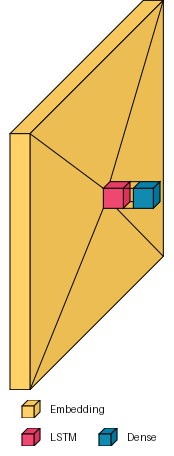

In [26]:
visualkeras.layered_view(model, legend=True)

Compiling the model with appropriate loss function and optimizer.
**Loss Function**:
- We use `sparse_categorical_crossentropy` because the target output is a single integer (not one-hot encoded).

**Optimizer**:
- `Adam` is used for its adaptive learning rate, helping the model converge faster and more reliably during training.


In [29]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Prepare data for training

In [ ]:
# Convert sequences and targets to NumPy arrays
X = np.array(sequences)
y = np.array(targets)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Train set shape: (15246045, 100)
Validation set shape: (1694006, 100)


In [27]:
# Count total number of batches
dataset_size = dataset.cardinality().numpy()

# fallback if cardinality is infinite (happens sometimes)
if dataset_size == tf.data.INFINITE_CARDINALITY:
    dataset_size = 0
    for _ in dataset:
        dataset_size += 1

print(f"Total dataset size: {dataset_size}")

# Calculate split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size  # to ensure full coverage

# Split datasets
train_dataset = dataset.take(train_size)
val_test_dataset = dataset.skip(train_size)

val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

print(f"Train batches: {train_size}")
print(f"Validation batches: {val_size}")
print(f"Test batches: {test_size}")


Total dataset size: -2
Train batches: -1
Validation batches: 0
Test batches: -1


Training the Model

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=10,
    verbose=1
)

Epoch 1/10
  2952/119110 ━━━━━━━━━━━━━━━━━━━━ 10:37:03 329ms/step - accuracy: 0.3258 - loss: 2.3777

In [31]:
# Train your model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=128,
    epochs=10
)

Epoch 1/10
  38469/Unknown 741s 19ms/step - accuracy: 0.5369 - loss: 1.5128

KeyboardInterrupt: 

Visualizing Model Accuracy and Loss

In [ ]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Step 2 Summary

- The RNN uses an Embedding layer to learn dense vector representations of characters.
- An LSTM layer with 128 units captures temporal dependencies in character sequences.
- A Dense layer with `softmax` outputs the probability distribution over the vocabulary.

Compiled with `sparse_categorical_crossentropy` and `adam`, the model learns to predict the next character in a sequence.


# Step 3

1. Create a function to generate text by sampling from the model's predictions.

Qualitative Evaluation:

2. Coherence and Grammar: Check if the generated text is grammatically correct and coherent.

3. Creativity: Evaluate if the generated text is creative and interesting.

4. Contextual Relevance: Assess whether the generated text maintains context and follows logically from the seed text.

5. Diversity: Ensure that the model does not repeat itself excessively and generates diverse outputs.

Quantitative Evaluation:

6. Perplexity: A common metric for evaluating language models. Perplexity measures how well the model predicts the next token in a sequence. Lower perplexity indicates better performance.

7. BLEU Score: Used to evaluate the quality of text that has been machine-translated from one language to another. It can be adapted to measure the overlap between generated text and reference text.

8. ROUGE Score: Commonly used for evaluating summarization and translation models. It measures the overlap of n-grams between the generated text and a reference text.

9. Entropy and Repetition Metrics: Measure the diversity of the generated text. High entropy and low repetition indicate diverse and less repetitive outputs.




# Step 4

1. Experiment with different architectures (e.g., adding more layers, or trying other layer types).
 * Try deeper networks, different activation functions, or different layer configurations.
 * Example: Adding more LSTM layers or using GRU instead of LSTM.
2. Apply regularization techniques (e.g., Use dropout to prevent overfitting).
3. Use advanced text preprocessing.
 * Implement techniques like stemming, lemmatization, or BPE (Byte Pair Encoding) for
better tokenization.
4. Fine-tune hyperparameters (e.g., learning rate, batch size).
 * Experiment with different learning rates, batch sizes, and epochs.
 * Explain your approach for fine-tuning the hyper-parameters.